## 1. Load and Prepare the Data

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Spark Session
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

# Load data
movies = spark.read.csv('../data/intermediate/filtered_movies.tsv', sep='\t', header=True, inferSchema=True)
users = spark.read.csv('../data/intermediate/filtered_users.tsv', sep='\t', header=True, inferSchema=True)
user_ratings = spark.read.csv('../data/intermediate/filtered_user_ratings.tsv', sep='\t', header=True, inferSchema=True)


In [7]:
schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)
])

# Load the training data
train = spark.read.csv("../data/raw/u1.base", sep="\t", schema=schema, header=False)

# Load the test data
test = spark.read.csv("../data/raw/u1.test", sep="\t", schema=schema, header=False)


In [8]:
# check the data types of all columns
user_ratings.printSchema()

users.printSchema()

movies.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- user_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zip_code: string (nullable = true)

root
 |-- movie_id: integer (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- release_date: integer (nullable = true)
 |-- genre_1: integer (nullable = true)
 |-- genre_2: integer (nullable = true)
 |-- genre_3: integer (nullable = true)
 |-- genre_4: integer (nullable = true)
 |-- genre_5: integer (nullable = true)
 |-- genre_6: integer (nullable = true)
 |-- genre_7: integer (nullable = true)
 |-- genre_8: integer (nullable = true)
 |-- genre_9: integer (nullable = true)
 |-- genre_10: integer (nullable = true)
 |-- genre_11: integer (nullable = true)
 |-- genre_12: integer (nullable = true)
 |-- genre_13

## 2. Model Creation and Evaluation

In [ ]:
# Build the ALS Model with initial parameters with seed 42  reproducibility
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop", seed = 42)

# Define a parameter grid to search over
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .addGrid(als.maxIter, [5, 10]) \
    .addGrid(als.regParam, [0.01, 0.1]) \
    .build()

# Define an evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Setup CrossValidator
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Adjust numFolds as needed

# Fit the model using cross-validation
cvModel = crossval.fit(train)  # Assuming 'user_ratings' is your training dataset

# Make predictions on the test data
predictions = cvModel.transform(test)  # Assuming 'test' is your test dataset

In [30]:
# Extracting the best model from the cross-validation results
cvModel = cvModel.bestModel

# Displaying the optimal hyperparameters of the best model
# Retrieving the best 'rank' parameter
print("Optimal Rank:", cvModel._java_obj.parent().getRank())
# Retrieving the best 'regParam' (regularization parameter)
print("Optimal regParam:", cvModel._java_obj.parent().getRegParam())
# Retrieving the best 'maxIter' (maximum number of iterations)
print("Optimal maxIter:", cvModel._java_obj.parent().getMaxIter())

Optimal Rank: 5
Optimal regParam: 0.1
Optimal maxIter: 10


In [10]:
# Evaluate the model using Root-mean-square error
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Evaluate the model using Mean-square error
mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
mse = mse_evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

Root-mean-square error = 0.9362871273788139
Mean Squared Error (MSE) on test data = 0.8766335848952713


## 3. Save the Model

In [ ]:
# Save the model
cvModel.write().save("../models/1.0-model")

## 4. Visualization
In a PySpark environment, direct visualization options are limited as compared to Python's libraries like Matplotlib, which are more suited for dataframes in Pandas. 
#### 4.1. Visualization the distribution of actual vs. predicted ratings.

c:\Users\Dasha\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dasha\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


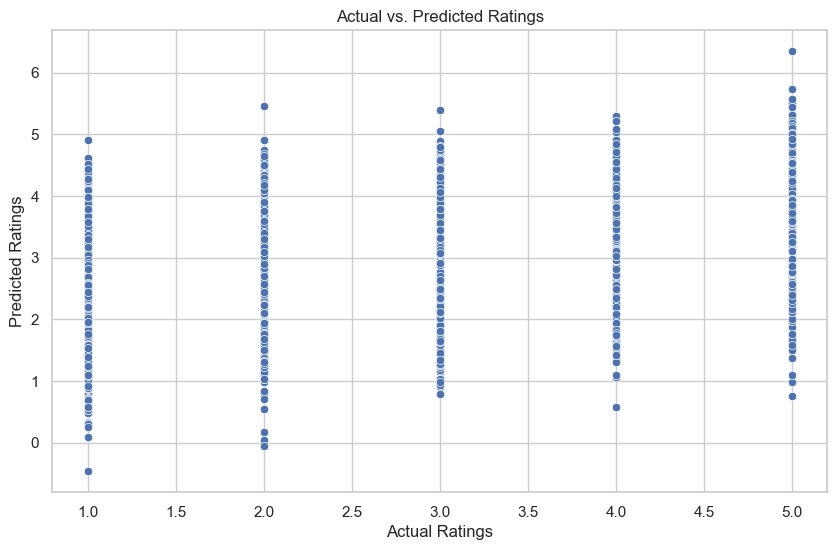

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Converting Spark DataFrame to Pandas DataFrame
predictions_pd = predictions.toPandas()

# Setting up the visualization style
sns.set(style="whitegrid")

# Plotting the actual vs. predicted ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x="rating", y="prediction", data=predictions_pd)

plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

This scatter plot shows the predicted ratings by the model against the actual ratings given by users. Each column represents an actual rating value (1.0 to 5.0), and the spread of points along the y-axis for each column shows the range of predictions for that rating. Ideally, for a perfect prediction, all points would lie on a line where the actual ratings equal the predicted ratings (a 45-degree line going from the bottom left to the top right of the chart). However, the spread of points suggests variability in prediction accuracy. The model has a consistent spread across all rating values, suggesting that there isn't a particular bias towards over or under predicting in any specific rating category.

#### 4.2. Error Analysis Visualization

c:\Users\Dasha\miniconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dasha\miniconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


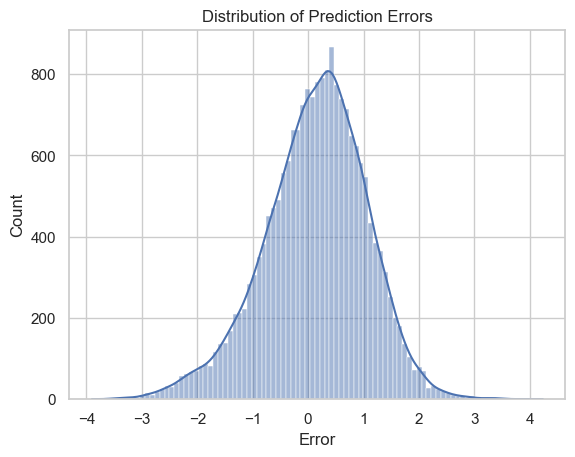

In [33]:
predictions_pd['error'] = predictions_pd['rating'] - predictions_pd['prediction']
sns.histplot(predictions_pd['error'], kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.show()

This histogram shows the distribution of prediction errors, which is the difference between the actual and predicted ratings. The chart shows a normal distribution of errors centered around 0, indicating that the model has a symmetrical error distribution with most predictions being close to the actual value. The bell shape of the curve suggests that the model's errors are normally distributed, which is a common assumption in many statistical models and is often an indicator of a well-fitting model.